In [1]:
# import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
#upload the dataset
data = pd.read_csv("https://github.com/muluwork-shegaw/10Acad_week4/blob/master/ABAdRecall.csv?raw=true",error_bad_lines=False)

### Exploring the dataset

In [ ]:
data.head() # glance  our dataset

In [ ]:
data.describe() #description of the dataset

In [13]:
print('This dataset has '+str(data.shape[0])+' rows, and '
                         +str(data.shape[1])+ ' columns')


This dataset has 8077 rows, and 9 columns


In [ ]:
data.info() #summery
# This shows us the different data types and number of non-null values in
#each columns

 **NB :**
- As we can show in the summery ,we have totally 8077 data and there is no null values.

In [ ]:
data.nunique().sort_values(ascending=False) # number of unique  values in each vriable

In [16]:
sample_data = data[np.logical_or(data['yes']==1,data['no']==1)]
sample_data.shape # the data which contain who has  animpression to answer for 

(1243, 9)

 **NB :**
- the data which contain who has an impression to answer for BIO questionarie and they actually reply as "yes" or "no"

### Overview

In [17]:
# plot multiple his in one graph
def multple_hist(data,bins,legend,color):
    for i in range(len(data)):
        plt.hist(data[i], bins, color=color[i], alpha=0.5)
        plt.legend(legend)
    plt.show()

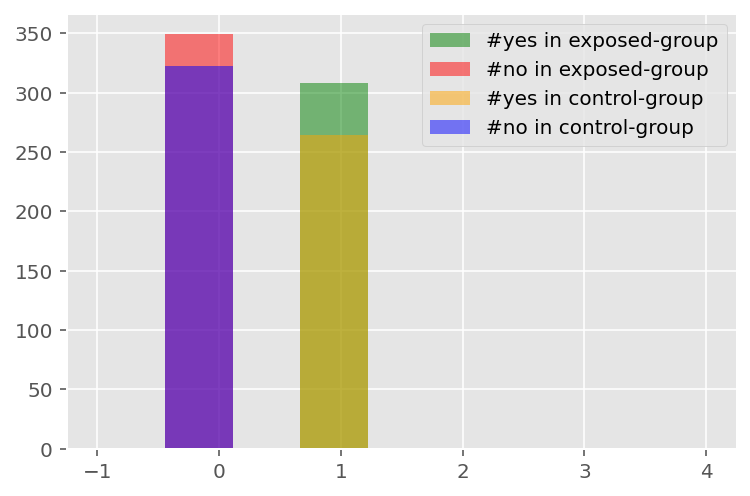

In [18]:
this_data = sample_data[['experiment','yes','no']]
exposed = this_data[this_data["experiment"] == "exposed"]
control = this_data[this_data["experiment"] == "control"]

datas = [exposed[exposed['yes']==1]['yes'],exposed[exposed['yes']==0]['yes'],
         control[control['yes']==1]['yes'],control[control['yes']==0]['yes']]

legend = ["#yes in exposed-group","#no in exposed-group",
          "#yes in control-group","#no in control-group"]
bins = np.linspace(-1, 4, 10)
color=["green","red","orange","blue"]

multple_hist(datas,bins,legend,color)

**NB:**
- The above figure shows us the distribution of the answers of the BIO(brand impact optimizer) for the users who are under the exposed and control group. 

- when we see histogram the count of yes is less than count no, which means most users don't know the brand smartAd.

**But when we compare the count of #yes in exposed and in control group ,the exposed group more know the brand smartAd than control group.** 
- #yes in exposed group is between  300 and 350
- #yes in control group is between  250 and 300


## Task 2: Analysis 
#### Task 2.1 : Classic and sequential A/B testing analysis


- Perform hypothesis testing: apply the classical p-value based algorithm and the  sequential A/B testing algorithm for which a starter code is provided..